# 4. Evaluation Metrics for Classification
## Homework

In this homework, we will use [Credit Card Data]((https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv)) from book "Econometric Analysis". 

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('../data/AER_credit_card_data.csv')

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [6]:
df.card = (df.card == 'yes').astype(int)

In [7]:
df.head(15)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
5,1,0,23.25000,2.5000,0.044438,91.996670,no,no,0,54,1,1
6,1,0,27.91667,3.9600,0.012576,40.833330,no,no,2,7,1,5
7,1,0,29.16667,2.3700,0.076434,150.790000,yes,no,0,77,1,3
8,1,0,37.00000,3.8000,0.245628,777.821700,yes,no,0,97,1,6
9,1,0,28.41667,3.2000,0.019780,52.580000,no,no,0,65,1,18


In [8]:
def split_train_val_test(df, val_size, test_size, target, random_state):
    """
    Splits the dataset into 3 parts: train/validation/test with 
    (1-val_size-test_size)/val_size/test_size distribution. 
    Extracts the target variable from all datasets.
    """
    
    # Split the dataset into 2 parts: full_train/test with (train_size+val_size)/test_size distribution
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split the full_train dataset into 2 parts: train/val with train_size/val_size distribution
    df_train, df_val = train_test_split(df_full_train, test_size=val_size/(1-test_size), random_state=random_state)
    
    # Verify the lenghts of datasets
    print(len(df_train), len(df_val), len(df_test))
    
    # Reset indices of all datasets 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_full_train = df_full_train.reset_index(drop=True)
    
    # Extract target variable from all datasets 
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    # Delete target variable from all datasets 
    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

In [9]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_train_val_test(df, 0.2, 0.2, 'card', 1)

791 264 264


In [10]:
df_train.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
1,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
2,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
3,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
4,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4


In [11]:
y_val

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reports      791 non-null    int64  
 1   age          791 non-null    float64
 2   income       791 non-null    float64
 3   share        791 non-null    float64
 4   expenditure  791 non-null    float64
 5   owner        791 non-null    object 
 6   selfemp      791 non-null    object 
 7   dependents   791 non-null    int64  
 8   months       791 non-null    int64  
 9   majorcards   791 non-null    int64  
 10  active       791 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 68.1+ KB


In [13]:
df_train.dtypes

reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [14]:
def num_cat_features(df):
    """
    Returns lists of numerical features and categorical features of the dataset
    """
    numerical = []
    categorical = []

    for col in df.columns.values:
        if df.dtypes.loc[col] == 'O':
            categorical.append(col)
        else:
            numerical.append(col)
            
    return numerical, categorical

In [15]:
numerical, categorical = num_cat_features(df_train)

In [16]:
numerical

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [17]:
categorical

['owner', 'selfemp']

In [18]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])       
    print(f'AUC(card, {col}) = {auc}')

AUC(card, reports) = 0.7166629860689376
AUC(card, age) = 0.5240020979407055
AUC(card, income) = 0.5908049467233478
AUC(card, share) = 0.989183643423692
AUC(card, expenditure) = 0.991042345276873
AUC(card, dependents) = 0.5327757227773791
AUC(card, months) = 0.5294217780967629
AUC(card, majorcards) = 0.5343859842838476
AUC(card, active) = 0.6043173411362006


**Answer 1.** The highest AUC has **`share`**.

# Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


In [19]:
df_train.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
1,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
2,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
3,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
4,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4


In [20]:
# Apply one-hot-encoding using DictVectorizer
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [21]:
# Train the logistic regression with given above parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [22]:
y_pred = model.predict_proba(X_val)[:, 1]

In [23]:
roc_auc_score(y_val, y_pred).round(3)

0.995

**Answer 2.** The AUC of this model on the validation dataset is **0.995**.

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

In [24]:
def scores_dataframe(y_val, y_pred):
    """
    creates a DataFrame with tp, fp, fn, tn, tpr, fpr, precision, recall, F1
    for all thresholds from 0.0 to 1.0 with step 0.01
    """
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        F1 = 2 * precision * recall / (precision + recall)
        

        scores.append((t, tp, fp, fn, tn, tpr, fpr, precision, recall, F1))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'tpr', 'fpr', 'precision', 'recall', 'F1']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [25]:
df_scores = scores_dataframe(y_val, y_pred)
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,F1
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,1.000000,0.584906,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,0.966825,0.000000,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085,0.980676
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346,0.978208


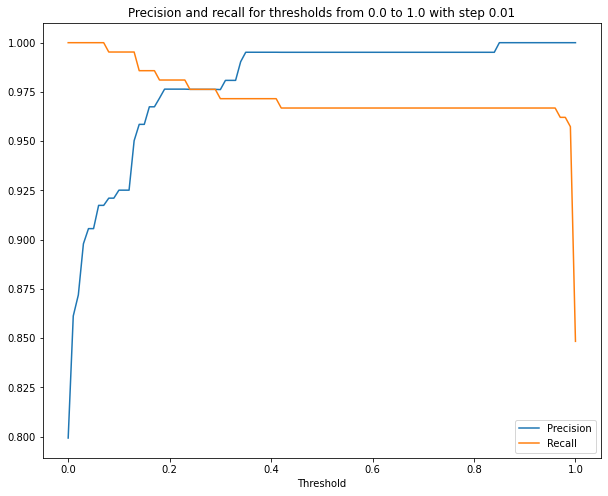

In [26]:
plt.figure(figsize=(10,8))
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision and recall for thresholds from 0.0 to 1.0 with step 0.01')
plt.legend()

**Answer 3.** Precision and recall curves intersect at threshold **0.3**.

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

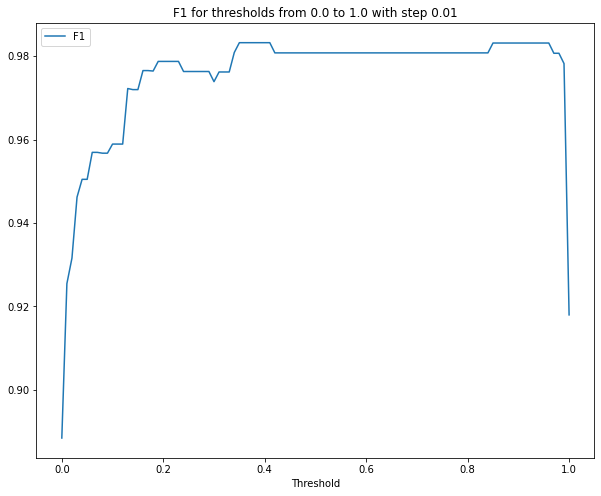

In [27]:
plt.figure(figsize=(10,8))
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.xlabel('Threshold')
plt.title('F1 for thresholds from 0.0 to 1.0 with step 0.01')
plt.legend()

**Answer 4.** F1 is maximal at threshold **0.4**.

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

In [28]:
def kfold_train_LR_get_score(df_full_train, n_splits, C, max_iter):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values
        
        train_dict = df_train[categorical + numerical].to_dict(orient="records")
        val_dict = df_val[categorical + numerical].to_dict(orient="records")

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
        model.fit(X_train, y_train)        
        y_pred = model.predict_proba(X_val)[:, 1]

        scores.append(roc_auc_score(y_val, y_pred))
    
    return scores

In [29]:
scores = kfold_train_LR_get_score(df_full_train, n_splits=5, C=1.0, max_iter=1000)

In [30]:
print('Scores:', *scores)
print(f'Mean score: {np.mean(scores).round(4)}')
print(f'Standard deviation of the score: {np.std(scores).round(4)}')

Scores: 0.9941860465116279 0.9941176470588236 0.9943346508563901 0.9996107939802803 1.0
Mean score: 0.9964
Standard deviation of the score: 0.0027


**Answer 5.** The standard deviation of the AUC scores across different folds is **0.003**.

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [31]:
for C in [0.01, 0.1, 1, 10]:
    scores = kfold_train_LR_get_score(df_full_train, n_splits=5, C=C, max_iter=1000)
    print('C = %s, score = %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C = 0.01, score = 0.992 +- 0.006
C = 0.1, score = 0.995 +- 0.004
C = 1, score = 0.996 +- 0.003
C = 10, score = 0.996 +- 0.003


**Answer 6.** **C=1** leads to the best mean score.